In [53]:
%matplotlib inline

import wikipedia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

In [54]:
f = pd.read_csv('full_performance_names.csv', header=None, names=['index','perf_name'])

In [55]:
titles = f.perf_name.tolist()

In [56]:
#get rid of NT (National Theatre) in front of some of the names
titles = [t[4:] if t[:3]=="NT -" else t for t in titles]

In [57]:
with open("descriptions.txt") as desc:
    descriptions = desc.readlines()
descs = []
tempDesc = ''
for description in descriptions:
    if description == '\n':
        descs.append(tempDesc)
        tempDesc = ''
    else:
        tempDesc += description[:-1].decode('utf-8')
descs.append(tempDesc)

In [58]:
manually_fixed_wiki = {
    'The Silk Road Ensemble': 'Joseph Gramley',
    'Royal Shakespeare Company Live in HD: Richard II': 'Richard the Second',
    'New Century Chamber Orchestra: Nadja Salerno-Sonnenberg  violin and leader': 'New Century Chamber Orchestra',
    '1927: The Animals and Children Took to the Streets': 'Wole Oguntokun',
    'Kodo':'Kodo (taiko group)',
    'One Night in Bamako': 'Bassekou Kouyate',
    'One Man, Two Gu': 'One Man, Two Guvnors',
    'People': 'no page',
    'FAM -Aspen Santa Fe':'no page',
    'AnDa Union': 'no page',
    'Collaborators': 'Collaborators (play)',
    'Chamber Ensemble of the Shanghai Chinese Orchestra':'Shanghai Chinese Orchestra'
}

In [59]:
#augment current descriptions with information from wikipedia
for i in range(len(titles)):
    
    if titles[i] in manually_fixed_wiki.keys():
        temp_title = manually_fixed_wiki[titles[i]]
    else:
        temp_title = titles[i]
    
    if temp_title != 'no page': 
        searchResults = wikipedia.search(temp_title)

        #use first search result
        if(len(searchResults) > 0):
            try:
                pageContent = wikipedia.page(searchResults[0]).content
                print(titles[i],'*',searchResults[0])
            except wikipedia.exceptions.DisambiguationError as e:
                try: #TODO: something really weird going on with a few cases of multiple disambiguation errors
                    pageContent = wikipedia.page(e.options[0]).content
                    print(titles[i],'*',e.options[0])
                except:
                    ;#Alright, give up

            descs[i] += pageContent

('The Infernal Comedy', '*', u'Musica Angelica Baroque Orchestra')
('Yuja Wang', '*', u'Yuja Wang')
('London Philharmonic', '*', u'London Philharmonic Orchestra')
('Hamburg Symphony', '*', u'Hamburger Symphoniker')
('Chicago Symphony Orchestra', '*', u'Chicago Symphony Orchestra')
('San Francisco Symphony', '*', u'San Francisco Symphony')
('Pavel Haas Quartet', '*', u'Pavel Haas Quartet')
('Ballet Preljocaj', '*', u'Angelin Preljocaj')
('Joshua Bell', '*', u'Joshua Bell')
('Murray Perahia', '*', u'Murray Perahia')
('Mariinsky Orchestra', '*', u'Mariinsky Theatre Orchestra')
('Detroit Symphony Orchestra', '*', u'Detroit Symphony Orchestra')
('New York Philharmonic', '*', u'New York Philharmonic')
('Artemis Quartet', '*', u'Artemis Quartet')
('Anne-Sophie Mutter,', '*', u'Anne-Sophie Mutter')
('Bobby McFerrin', '*', u'Bobby McFerrin')
('Alison Balsom', '*', u'Alison Balsom')
('SITI: Trojan Women', '*', u'Anne Bogart')
('Audra McDonald', '*', u'Audra McDonald')
('Andras Schiff', '*', u'An

In [62]:
# Extract bigram matrix
vect = CountVectorizer(ngram_range=(1, 1), stop_words = ENGLISH_STOP_WORDS, min_df = 5)
X = vect.fit_transform(descs)

print(X.shape)

(144, 3715)


In [68]:
#LDA
lda = LatentDirichletAllocation(n_topics=5, max_iter=50)
y = lda.fit_transform(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

print_top_words(lda, vect.get_feature_names(), 20)

Topic #0:
play shakespeare theatre production christopher book macbeth london novel story musical mother life comedy film national text version stage directed
Topic #1:
orchestra music symphony philharmonic hall piano brass recording recordings conductor concerto concert concerts violin mozart 2006 beethoven award new conducted
Topic #2:
new music york performed american university work arts works world state season century national group horses history city john building
Topic #3:
new festival film jordan york art dance jazz 2014 school water ballet company city 2011 international project 2010 2013 2012
Topic #4:
singer album music blake quartet released song american december jazz love new july september year february single january october time



In [69]:
topics = y.argmax(axis = 1)
df_topic = pd.DataFrame(topics, columns=['topic_num'])
df_topic['perf_name'] = f.perf_name

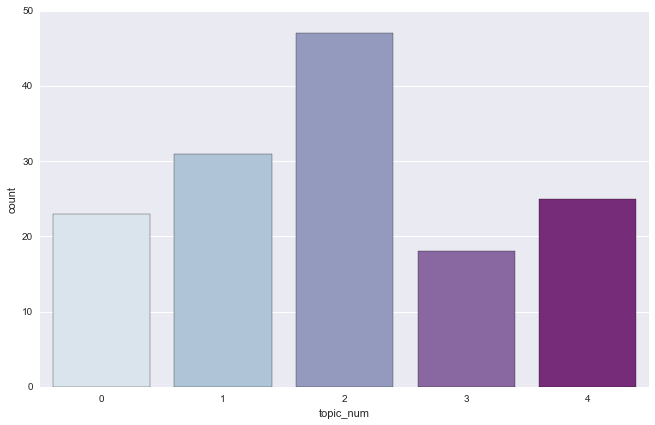

In [70]:
topic_range = range(5)
sns.factorplot(x = 'topic_num', data = df_topic, kind = 'count', palette="BuPu", size=6, aspect=1.5, order = topic_range)